In [1]:
# Copyright (c) 2020, The University of Texas at Austin, University of
# California, Merced, & Washington University
#
# All Rights reserved.
# See file COPYRIGHT for details.
#
# This file is part of the hIPPYlib library. For more information and source code
# availability see https://hippylib.github.io.
#
# hIPPYlib is free software; you can redistribute it and/or modify it under the
# terms of the GNU General Public License (as published by the Free
# Software Foundation) version 2.0 dated June 1991.

import sys
import os

import numpy as np
import matplotlib.pyplot as plt

import dolfin as dl

import hippylib as hp

from iceModel import *


In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

In [3]:
def extract_boundary(V, msh, w_vec, n_mfold):
    counter = 0
    mfold_X = np.zeros(n_mfold)
    mfold_U = np.zeros(n_mfold)
    v2d = dl.vertex_to_dof_map(V)
    
    for vertex in dl.vertices(msh):
         if vertex.x(1) == 0.:
             mfold_X[counter] = vertex.x(0)
             mfold_U[counter] = w_vec[v2d[vertex.index()]]
             counter += 1
    mfold_pairs = [(mfold_X[i], mfold_U[i]) for i in range(n_mfold)]
    return mfold_X, mfold_U

class PeriodicBoundary(dl.SubDomain):
    
    def inside(self, x, on_boundary):
        return dl.near(x[0], 0)  and on_boundary
    
    def map(self, x, y):
        y[0] = x[0] - Length
        y[1] = x[1]

class BasalBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return dl.near(x[1], 0) and on_boundary


In [4]:
dl.set_log_active(False)
ndim = 2
    
# Reduce order of quadrature
dl.parameters['form_compiler']['quadrature_degree'] = 4

# Number of pixels
nx = 20
nz = 10
    
# Physical dimensions
Length = 10000.0
Height = 1000.0
    
# forcing term
angle = .1*dl.pi/180.0
grav = 9.81
rho = 910.0

# rheology
n = 3.0
A = dl.Constant(1e-16)
    
    
# Meshing and boundaries
mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(Length, Height), nx,  nz)
pbc = PeriodicBoundary()
basal_bnd = BasalBoundary()
    

"""
Taylor-hood elements for the finite-element discretization of the state-pressure variable
"""    
P1 = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
P2 = dl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
TH = P2 * P1
Vh2 = dl.FunctionSpace(mesh, TH, constrained_domain=pbc) #periodic product space for state + adjoint
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1, constrained_domain=pbc)

"""
Collection of function spaces,
1st is for the state
2nd is for the parameter
3rd is for the adjoint
"""
Vh = [Vh2, Vh1, Vh2]
    
ndofs = [Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim()]
print ("Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs))

# ==== SET UP FORWARD MODEL ====
# Forcing term
f=dl.Constant( ( rho*grav*np.sin(angle), -rho*grav*np.cos(angle) ) )

# Dirichlet condition. The first sub(0) gets the velocity, sub(1) gets the z-compoenet of velocity
bc = dl.DirichletBC(Vh[hp.STATE].sub(0).sub(1), dl.Constant(0.0), basal_bnd)
bc0 = dl.DirichletBC(Vh[hp.STATE].sub(0).sub(1), dl.Constant(0.0), basal_bnd)

# Base Sliding boundary marker
boundary_markers = dl.MeshFunction("size_t", mesh, mesh.geometry().dim() - 1)
boundary_markers.set_all(0)
"""
label basal boundary as 1 note ds(1) below
"""
basal_bnd.mark(boundary_markers,1)
ds = dl.Measure("ds",domain=mesh, subdomain_data=boundary_markers)

normal = dl.FacetNormal(mesh)

Number of dofs: STATE=1900, PARAMETER=220, ADJOINT=1900


In [5]:
# Define the Nonlinear stoke varfs
nonlinearStokesFunctional = NonlinearStokesForm(n, A, normal, ds(1), f)
    
# Create one-hot vector on pressure dofs
constraint_vec = dl.interpolate( dl.Constant((0,0,1)), Vh[hp.STATE]).vector()

pde = EnergyFunctionalPDEVariationalProblem(Vh, nonlinearStokesFunctional, constraint_vec, bc, bc0)
    
# ==== SET UP PRIOR DISTRIBUTION ====
gamma = 1.e1
delta = gamma*1e-3
prior_mean_val = 7.
prior_mean = dl.interpolate(dl.Constant(prior_mean_val), Vh[hp.PARAMETER]).vector()
prior = hp.BiLaplacianPrior(Vh[hp.PARAMETER], gamma, delta, mean = prior_mean, robin_bc=False)
    
# ==== SET UP DATA FIDELITY TERM ====
# ntargets equally distributed observation points close to the top boundary
ntargets = 15
targets = np.zeros((ntargets,  ndim), dtype = np.float64 )
targets[:,0] = np.linspace(Length/float(2*ntargets), Length*(1.-1./float(2*ntargets) ), ntargets)
targets[:,1] = (0.99999999*Height)*np.ones(ntargets, dtype = np.float64)
    
# Only observe tangential velocity
component_observed = dl.interpolate( dl.Constant((1,0,0)), Vh[hp.STATE]).vector()
    
misfit = PointwiseProjectedStateObservation(Vh[hp.STATE], targets, component_observed)

In [6]:
# Define ground truth image basal sliding
m_func = dl.Expression('m0 + 2.0*std::sin(x[0]*2.*pi/Length)', \
        element=Vh[hp.PARAMETER].ufl_element(), m0=prior_mean_val, Length=Length)
mtrue = dl.interpolate(m_func, Vh[hp.PARAMETER]).vector()

In [7]:
# Compute the state at ground truth
utrue = pde.generate_state()
pde.solveFwd(utrue, [utrue, mtrue, None])
    
misfit.B.mult(utrue, misfit.d)
noise_std_dev = misfit.d.norm("linf")*0.01
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

In [8]:
# ==== Define the model ====
model = hp.Model(pde, prior, misfit)
    
# ==== Map Point reconstruction ====
m = prior.mean.copy()
parameters = hp.ReducedSpaceNewtonCG_ParameterList()
parameters["rel_tolerance"] = 1e-8
parameters["abs_tolerance"] = 1e-12
parameters["max_iter"]      = 100
parameters["globalization"] = "LS"
parameters["GN_iter"] = 10
parameters["cg_coarse_tolerance"] = 0.5
        
solver = hp.ReducedSpaceNewtonCG(model, parameters)
x = solver.solve([None, m, None])
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print ("Termination reason: ", solver.termination_reasons[solver.reason])
print ("Final gradient norm: ", solver.final_grad_norm)
print ("Final cost: ", solver.final_cost)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    8.305701e+02    8.264961e+02    4.074046e+00   -3.680798e+04   1.841497e+02   1.000000e+00   5.000000e-01
  2   1    3.300849e+02    3.238257e+02    6.259212e+00   -1.002938e+03   2.093746e+01   1.000000e+00   3.371914e-01
  3   2    2.334628e+02    2.249476e+02    8.515192e+00   -5.226407e+02   1.194315e+00   2.500000e-01   8.053301e-02
  4   2    2.169350e+02    1.985632e+02    1.837174e+01   -3.360040e+02   3.541467e+00   5.000000e-01   1.386775e-01
  5   1    1.055339e+02    8.873094e+01    1.680298e+01   -2.230824e+02   8.395604e+00   1.000000e+00   2.135209e-01
  6   2    7.513282e+01    3.743542e+01    3.769739e+01   -8.330350e+01   4.225296e-01   1.000000e+00   4.790083e-02
  7   1    6.506233e+01    2.789658e+01    3.716576e+01   -2.015385e+01   2.395546e+00   1.000000e+00   1.140556e-01
  8   5    6.448757e+01    2.782309e+01    3.666448e+01   -2.

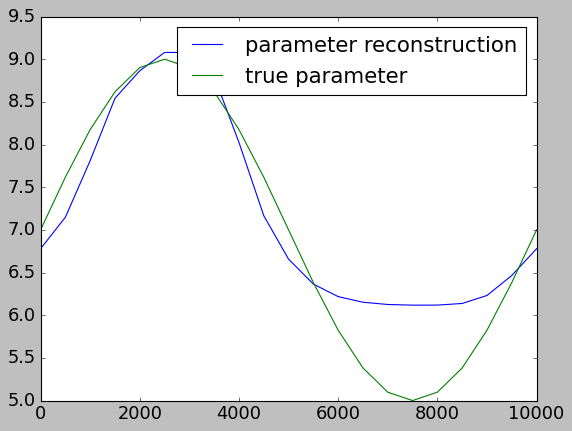

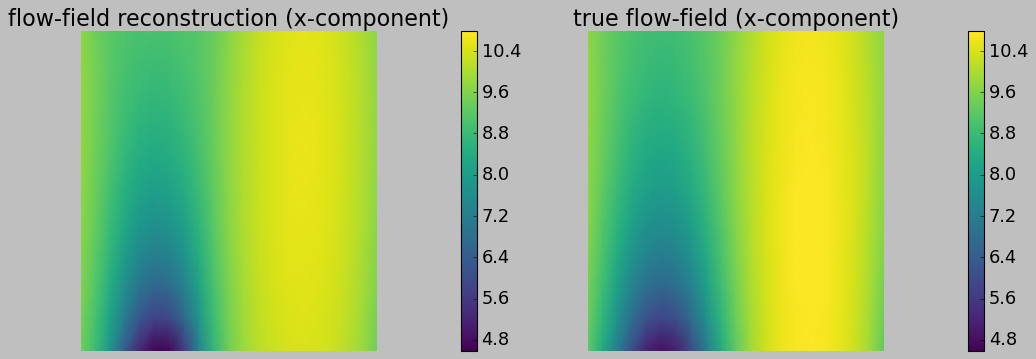

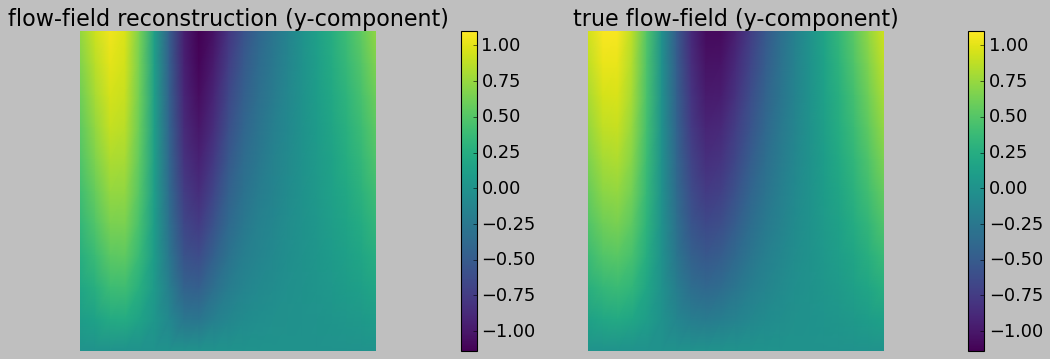

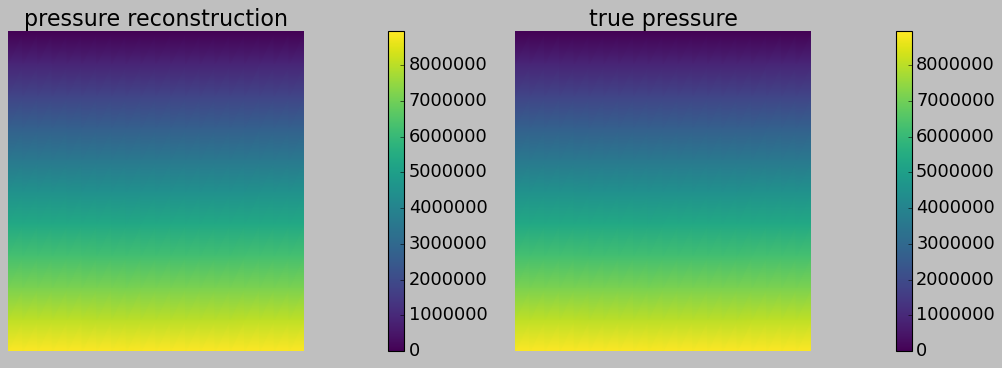

In [9]:
X, Mreconstruction = extract_boundary(Vh[hp.PARAMETER], mesh, x[hp.PARAMETER], nx+1)
X, Mtrue          = extract_boundary(Vh[hp.PARAMETER], mesh, mtrue, nx+1)
    
plt.plot(X, Mreconstruction, label='parameter reconstruction')
plt.plot(X, Mtrue, label='true parameter')
plt.legend()
plt.show()
    
uReconstruction = hp.vector2Function(x[hp.STATE], Vh[hp.STATE])
uTrue           = hp.vector2Function(utrue, Vh[hp.STATE])

hp.nb.multi1_plot([uReconstruction.sub(0).sub(0, deepcopy=True), uTrue.sub(0).sub(0, deepcopy=True)],\
                  ["flow-field reconstruction (x-component)", "true flow-field (x-component)"])
plt.show()
    
hp.nb.multi1_plot([uReconstruction.sub(0).sub(1, deepcopy=True), uTrue.sub(0).sub(1, deepcopy=True)], \
                  ["flow-field reconstruction (y-component)", "true flow-field (y-component)"])
plt.show()
    
hp.nb.multi1_plot([uReconstruction.sub(1, deepcopy=True), uTrue.sub(1, deepcopy=True)], \
                  ["pressure reconstruction", "true pressure"])
plt.show()
